# Useful Resources

- https://colab.research.google.com/github/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb

# Prepare

In [1]:
# !pip install -q tqdm
# !pip install -q conllu
# !pip install -q seaborn
# !pip install -q datasets
# !pip install -q scikit-learn
# !pip install -q pytorch_lightning
# !pip install -q git+https://github.com/MagedSaeed/tkseem

run the below line when needed, like in jupyter lab to access dotless_arabic folder.

In [2]:
# %cd ../../../.. 

In [3]:
import re
import os
import random
import string
import shutil
from pathlib import Path
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint,Callback,RichProgressBar

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

from dotless_arabic.processing import undot
from dotless_arabic.callbacks import EpochTimerCallback

In [4]:
seed = 42

In [5]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

Global seed set to 42


42

In [6]:
tqdm.pandas()

In [7]:
nltk.download('stopwords')
stopwords = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/majed_alshaibani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load and explore the dataset

In [8]:
train_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['train'], # text is not there
  datasets.load_dataset("universal_dependencies", "ar_padt")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['train'], # text is not there
  # datasets.load_dataset("universal_dependencies", "en_lines")['train'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['train'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['train'], # does not have a train split
  # datasets.load_dataset("universal_dependencies", "en_pud")['train'], # does not have a train split
])
train_dataset

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 6075
})

In [9]:
validation_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['train'], # text is not there
  datasets.load_dataset("universal_dependencies", "ar_padt")['validation'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['train'], # text is not there
  # datasets.load_dataset("universal_dependencies", "en_lines")['train'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['train'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['train'], # does not have a train split
  # datasets.load_dataset("universal_dependencies", "en_pud")['train'], # does not have a train split
])
validation_dataset

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 909
})

In [10]:
test_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['test'],
  datasets.load_dataset("universal_dependencies", "ar_padt")['test'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['test'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['test'],
  # datasets.load_dataset("universal_dependencies", "en_lines")['test'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['test'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['test'],
  # datasets.load_dataset("universal_dependencies", "en_pud")['test'],
])
test_dataset

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 680
})

Converting to Pandas and droping duplicates

In [11]:
train_dataset = train_dataset.to_pandas()
train_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,afp.20000715.0075:p1u1,برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[بَرلِين, رَفَض, حُصُول, شَرِكَة, أَمِيرِكِيّ,...","[12, 16, 0, 0, 6, 2, 0, 0, 0, 1, 12, 1, 6]","[X---------, VIIA-3FS--, N------S4R, N------S2...","[{'Foreign': 'Yes'}, {'Aspect': 'Imp', 'Gender...","[2, 0, 2, 3, 4, 7, 3, 7, 8, 11, 9, 11, 9]","[nsubj, root, obj, nmod, amod, case, obl:arg, ...","[[('nsubj', 2)], [('root', 0)], [('obj', 2)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root..."
1,afp.20000715.0075:p2u1,برلين 15-7 (اف ب) - افادت صحيفة الاحد الالماني...,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[بَرلِين, 15, -, 7, (, اف, ب, ), -, أَفَاد, صَ...","[12, 3, 1, 3, 1, 12, 12, 1, 1, 16, 0, 0, 6, 1,...","[X---------, Q---------, G---------, Q--------...","[{'Foreign': 'Yes'}, {'NumForm': 'Digit'}, Non...","[0, 1, 4, 2, 7, 7, 1, 7, 10, 1, 10, 11, 11, 17...","[root, dep, punct, conj, punct, nmod, dep, pun...","[[('root', 0)], [('dep', 1)], [('punct', 4)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root..."
2,afp.20000715.0075:p3u1,وفي نيسان/ابريل الماضي، تخلت الدولة الاسبانية ...,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, وَ, فِي, نِيسَان, /, أَبرِيل, مَاضِي, ،, ت...","[13, 9, 2, 0, 1, 0, 6, 1, 16, 0, 6, 2, 0, 1, 1...","[None, C---------, P---------, N------S2I, G--...","[None, None, {'AdpType': 'Prep'}, {'Case': 'Ge...","[None, 0, 3, 8, 5, 3, 3, 6, 1, 8, 9, 12, 8, 15...","[_, root, case, obl, punct, appos, amod, punct...","[None, [('root', 0)], [('case', 3)], [('obl:فِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,afp.20000715.0075:p4u1,وكانت خسائر المجموعة الاسبانية الرسمية تراكمت ...,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, وَ, كَان, خَسَارَة, مَجمُوعَة, إِسبَانِيّ,...","[13, 9, 16, 0, 0, 6, 6, 16, 2, 0, 3, 6, 13, 9,...","[None, C---------, VP-A-3FS--, N------P1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 3, 2, 9, 7, 9, 9, None, ...","[_, root, parataxis, nsubj, nmod, amod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,afp.20000715.0075:p5u1,واشارت صحيفة الاحد الى ان المستشار شرودر يعتبر...,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, وَ, أَشَار, صَحِيفَة, أَحَد, إِلَى, أَنَّ,...","[13, 9, 16, 0, 0, 2, 5, 0, 12, 16, 5, 0, 0, 6,...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 9, 9, 9, 7, 2, 19, 19, 11, ...","[_, root, parataxis, nsubj, nmod, mark, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
6070,xinhua.20030511.0192:p3u1,تلقى وزير الخارجية المصرى احمد ماهر هنا مساء ا...,"[تلقى, وزير, الخارجية, المصرى, احمد, ماهر, هنا...","[تَلَقَّى, وَزِير, خَارِجِيَّة, مِصرِيّ, احمد,...","[16, 0, 0, 6, 12, 12, 12, 12, 0, 12, 0, 6, 2, ...","[VP-A-3MS--, N------S1R, N------S2D, A-----MS1...","[{'Aspect': 'Perf', 'Gender': 'Masc', 'Number'...","[0, 1, 2, 2, 6, 2, 1, 1, 8, 8, 1, 11, 14, None...","[root, nsubj, nmod, amod, nmod, nmod, obl, obl...","[[('root', 0)], [('nsubj', 1)], [('nmod:gen', ...","[{'Vform': 'تَلَقَّى', 'Gloss': 'receive', 'Ro..."
6071,xinhua.20030511.0192:p4u1,وقالت وكالة انباء الشرق الاوسط المصرية ان شعث ...,"[وقالت, و, قالت, وكالة, انباء, الشرق, الاوسط, ...","[_, وَ, قَال, وِكَالَة, نَبَأ, شَرق, أَوسَط, م...","[13, 9, 16, 0, 0, 0, 6, 6, 5, 12, 16, 12, 0, 0...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 5, 3, 10, 10, 2, 10, 10,...","[_, root, parataxis, nsubj, nmod, nmod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
6072,xinhua.20030511.0192:p5u1,واكد شعث فى الاتصال على ضرورة قبول الجانب الإس...,"[واكد, و, 

In [12]:
train_dataset = train_dataset.drop_duplicates(subset=['text'],keep='first').copy()
train_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,afp.20000715.0075:p1u1,برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[بَرلِين, رَفَض, حُصُول, شَرِكَة, أَمِيرِكِيّ,...","[12, 16, 0, 0, 6, 2, 0, 0, 0, 1, 12, 1, 6]","[X---------, VIIA-3FS--, N------S4R, N------S2...","[{'Foreign': 'Yes'}, {'Aspect': 'Imp', 'Gender...","[2, 0, 2, 3, 4, 7, 3, 7, 8, 11, 9, 11, 9]","[nsubj, root, obj, nmod, amod, case, obl:arg, ...","[[('nsubj', 2)], [('root', 0)], [('obj', 2)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root..."
1,afp.20000715.0075:p2u1,برلين 15-7 (اف ب) - افادت صحيفة الاحد الالماني...,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[بَرلِين, 15, -, 7, (, اف, ب, ), -, أَفَاد, صَ...","[12, 3, 1, 3, 1, 12, 12, 1, 1, 16, 0, 0, 6, 1,...","[X---------, Q---------, G---------, Q--------...","[{'Foreign': 'Yes'}, {'NumForm': 'Digit'}, Non...","[0, 1, 4, 2, 7, 7, 1, 7, 10, 1, 10, 11, 11, 17...","[root, dep, punct, conj, punct, nmod, dep, pun...","[[('root', 0)], [('dep', 1)], [('punct', 4)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root..."
2,afp.20000715.0075:p3u1,وفي نيسان/ابريل الماضي، تخلت الدولة الاسبانية ...,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, وَ, فِي, نِيسَان, /, أَبرِيل, مَاضِي, ،, ت...","[13, 9, 2, 0, 1, 0, 6, 1, 16, 0, 6, 2, 0, 1, 1...","[None, C---------, P---------, N------S2I, G--...","[None, None, {'AdpType': 'Prep'}, {'Case': 'Ge...","[None, 0, 3, 8, 5, 3, 3, 6, 1, 8, 9, 12, 8, 15...","[_, root, case, obl, punct, appos, amod, punct...","[None, [('root', 0)], [('case', 3)], [('obl:فِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,afp.20000715.0075:p4u1,وكانت خسائر المجموعة الاسبانية الرسمية تراكمت ...,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, وَ, كَان, خَسَارَة, مَجمُوعَة, إِسبَانِيّ,...","[13, 9, 16, 0, 0, 6, 6, 16, 2, 0, 3, 6, 13, 9,...","[None, C---------, VP-A-3FS--, N------P1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 3, 2, 9, 7, 9, 9, None, ...","[_, root, parataxis, nsubj, nmod, amod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,afp.20000715.0075:p5u1,واشارت صحيفة الاحد الى ان المستشار شرودر يعتبر...,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, وَ, أَشَار, صَحِيفَة, أَحَد, إِلَى, أَنَّ,...","[13, 9, 16, 0, 0, 2, 5, 0, 12, 16, 5, 0, 0, 6,...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 9, 9, 9, 7, 2, 19, 19, 11, ...","[_, root, parataxis, nsubj, nmod, mark, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
6070,xinhua.20030511.0192:p3u1,تلقى وزير الخارجية المصرى احمد ماهر هنا مساء ا...,"[تلقى, وزير, الخارجية, المصرى, احمد, ماهر, هنا...","[تَلَقَّى, وَزِير, خَارِجِيَّة, مِصرِيّ, احمد,...","[16, 0, 0, 6, 12, 12, 12, 12, 0, 12, 0, 6, 2, ...","[VP-A-3MS--, N------S1R, N------S2D, A-----MS1...","[{'Aspect': 'Perf', 'Gender': 'Masc', 'Number'...","[0, 1, 2, 2, 6, 2, 1, 1, 8, 8, 1, 11, 14, None...","[root, nsubj, nmod, amod, nmod, nmod, obl, obl...","[[('root', 0)], [('nsubj', 1)], [('nmod:gen', ...","[{'Vform': 'تَلَقَّى', 'Gloss': 'receive', 'Ro..."
6071,xinhua.20030511.0192:p4u1,وقالت وكالة انباء الشرق الاوسط المصرية ان شعث ...,"[وقالت, و, قالت, وكالة, انباء, الشرق, الاوسط, ...","[_, وَ, قَال, وِكَالَة, نَبَأ, شَرق, أَوسَط, م...","[13, 9, 16, 0, 0, 0, 6, 6, 5, 12, 16, 12, 0, 0...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 5, 3, 10, 10, 2, 10, 10,...","[_, root, parataxis, nsubj, nmod, nmod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
6072,xinhua.20030511.0192:p5u1,واكد شعث فى الاتصال على ضرورة قبول الجانب الإس...,"[واكد, و, 

In [13]:
validation_dataset = validation_dataset.to_pandas()
validation_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,afp.20000715.0001:p1u1,ميراث ب300 الف دولار يقلب حياة متشرد اميركي,"[ميراث, ب, 300, الف, دولار, يقلب, حياة, متشرد,...","[مِيرَاث, بِ, 300, أَلف, دُولَار, قَلَّب, حَيَ...","[0, 2, 3, 3, 0, 16, 0, 6, 6]","[N------S1I, P---------, Q---------, QM-----S2...","[{'Case': 'Nom', 'Definite': 'Ind', 'Number': ...","[6, 3, 1, 3, 4, 0, 6, 7, 8]","[nsubj, case, nummod, nummod, nmod, root, obj,...","[[('nsubj', 6)], [('case', 3)], [('nummod', 1)...","[{'Vform': 'مِيرَاثٌ', 'Gloss': 'inheritance,h..."
1,afp.20000715.0001:p2u1,لونغ بيتش (الولايات المتحدة) 15-7 (اف ب)- كل ش...,"[لونغ, بيتش, (, الولايات, المتحدة, ), 15, -, 7...","[لُونغ, بِيتش, (, وِلَايَة, مُتَّحِد, ), 15, -...","[12, 12, 1, 0, 6, 1, 3, 1, 3, 1, 12, 12, 1, 1,...","[X---------, X---------, G---------, N------P1...","[{'Foreign': 'Yes'}, {'Foreign': 'Yes'}, None,...","[0, 1, 4, 1, 4, 4, 1, 7, 7, 1, 1, 1, 1, 1, 17,...","[root, flat:foreign, punct, appos, amod, punct...","[[('root', 0)], [('flat:foreign', 1)], [('punc...","[{'Vform': 'لُونغ', 'Gloss': 'Long', 'Root': '..."
2,afp.20000715.0001:p3u1,وغادر كنت (45 عاما) مساء الاربعاء المدينة متوج...,"[وغادر, و, غادر, كنت, (, 45, عاما, ), مساء, ال...","[_, وَ, غَادَر, كِنت, (, 45, عَام, ), مَسَاء, ...","[13, 9, 16, 12, 1, 3, 0, 1, 0, 0, 0, 6, 2, 0, ...","[None, C---------, VP-A-3MS--, X---------, G--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 3, 5, 5, 2, 8, 2, 2, 13, 11...","[_, root, parataxis, nsubj, punct, dep, nmod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,afp.20000715.0001:p4u1,وبدا ستيفن كنت نحيلا جدا، الا انه اغتسل وحلق ذ...,"[وبدا, و, بدا, ستيفن, كنت, نحيلا, جدا, ،, الا,...","[_, وَ, بَدَا, ستِيفِن, كِنت, نَحِيل, جِدّ, ،,...","[13, 9, 16, 12, 12, 6, 0, 1, 7, 13, 5, 11, 16,...","[None, C---------, VP-A-3MS--, X---------, X--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 2, 5, 6, 11, None, 11, 11, ...","[_, root, parataxis, nsubj, flat:foreign, xcom...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,afp.20000715.0001:p4u2,وبما ان المناسبة تستحق العناء اشترى سروالا ازر...,"[وبما, و, ب, ما, ان, المناسبة, تستحق, العناء, ...","[_, وَ, بِ, مَا, أَنَّ, مُنَاسَبَة, اِستَحَقّ,...","[13, 9, 2, 8, 5, 0, 16, 0, 16, 0, 6, 13, 9, 0,...","[None, C---------, P---------, S---------, C--...","[None, None, {'AdpType': 'Prep'}, None, None, ...","[None, 0, 3, 8, 6, 6, 3, 6, 1, 8, 9, None, 12,...","[_, root, case, obl, mark, nsubj, advcl, obj, ...","[None, [('root', 0)], [('case', 3)], [('obl:بِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
904,ummah.20040906.0013:p25u2,ـ لا نزورهم كونهم معتقلين لدى قوات التحالف.,"[ـ, لا, نزورهم, نزور, هم, كونهم, كون, هم, معتق...","[ـ, لَا, _, زَار, هُوَ, _, كَون, هُوَ, مُعتَقَ...","[1, 7, 13, 16, 11, 13, 0, 11, 0, 2, 0, 0, 1]","[G---------, F---------, None, VIIA-1MP--, SP-...","[None, None, None, {'Aspect': 'Imp', 'Gender':...","[3, 3, None, 0, 3, None, 3, 5, 3, 9, 3, 9, 3]","[punct, advmod, _, root, obj, _, obj, nmod, ob...","[[('punct', 3)], [('advmod', 3)], None, [('roo...","[{'Vform': 'ـ', 'Translit': None}, {'Vform': '..."
905,ummah.20040906.0013:p26u1,* ومتى سيتم تسليمهم إليكم؟,"[*, ومتى, و, متى, سيتم, س, يتم, تسليمهم, تسليم...","[*, _, وَ, مَتَى, _, سَ, تَمّ, _, تَسلِيم, هُو...","[1, 13, 9, 8, 13, 17, 16, 13, 0, 11, 13, 2, 11...","[G---------, None, C---------, S---------, Non...","[None, None, None, None, None, None, {'Aspect'...","[2, None, 0, 5, None, 5, 2, None, 5, 6, None, ...","[punct, _, root, obl, _, aux, parataxis, _, ns...","[[('punct', 2)], None, [('root', 0)], [('obl',...","[{'Vform': 'ذ', 'Translit': '*'}, None, {'Vfor..."
906,ummah.20040906.0013:p26u2,ـ سيتم تسليمهم إلى الحكومة العراقية المقبلة لت...,"[ـ, سيتم, س, يتم, تسليمهم, تسليم, هم, إلى, الح...","[ـ, _, سَ, تَمّ, _, تَسلِيم, هُوَ

In [14]:
validation_dataset = validation_dataset.drop_duplicates(subset=['text'],keep='first').copy()
validation_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,afp.20000715.0001:p1u1,ميراث ب300 الف دولار يقلب حياة متشرد اميركي,"[ميراث, ب, 300, الف, دولار, يقلب, حياة, متشرد,...","[مِيرَاث, بِ, 300, أَلف, دُولَار, قَلَّب, حَيَ...","[0, 2, 3, 3, 0, 16, 0, 6, 6]","[N------S1I, P---------, Q---------, QM-----S2...","[{'Case': 'Nom', 'Definite': 'Ind', 'Number': ...","[6, 3, 1, 3, 4, 0, 6, 7, 8]","[nsubj, case, nummod, nummod, nmod, root, obj,...","[[('nsubj', 6)], [('case', 3)], [('nummod', 1)...","[{'Vform': 'مِيرَاثٌ', 'Gloss': 'inheritance,h..."
1,afp.20000715.0001:p2u1,لونغ بيتش (الولايات المتحدة) 15-7 (اف ب)- كل ش...,"[لونغ, بيتش, (, الولايات, المتحدة, ), 15, -, 7...","[لُونغ, بِيتش, (, وِلَايَة, مُتَّحِد, ), 15, -...","[12, 12, 1, 0, 6, 1, 3, 1, 3, 1, 12, 12, 1, 1,...","[X---------, X---------, G---------, N------P1...","[{'Foreign': 'Yes'}, {'Foreign': 'Yes'}, None,...","[0, 1, 4, 1, 4, 4, 1, 7, 7, 1, 1, 1, 1, 1, 17,...","[root, flat:foreign, punct, appos, amod, punct...","[[('root', 0)], [('flat:foreign', 1)], [('punc...","[{'Vform': 'لُونغ', 'Gloss': 'Long', 'Root': '..."
2,afp.20000715.0001:p3u1,وغادر كنت (45 عاما) مساء الاربعاء المدينة متوج...,"[وغادر, و, غادر, كنت, (, 45, عاما, ), مساء, ال...","[_, وَ, غَادَر, كِنت, (, 45, عَام, ), مَسَاء, ...","[13, 9, 16, 12, 1, 3, 0, 1, 0, 0, 0, 6, 2, 0, ...","[None, C---------, VP-A-3MS--, X---------, G--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 3, 5, 5, 2, 8, 2, 2, 13, 11...","[_, root, parataxis, nsubj, punct, dep, nmod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,afp.20000715.0001:p4u1,وبدا ستيفن كنت نحيلا جدا، الا انه اغتسل وحلق ذ...,"[وبدا, و, بدا, ستيفن, كنت, نحيلا, جدا, ،, الا,...","[_, وَ, بَدَا, ستِيفِن, كِنت, نَحِيل, جِدّ, ،,...","[13, 9, 16, 12, 12, 6, 0, 1, 7, 13, 5, 11, 16,...","[None, C---------, VP-A-3MS--, X---------, X--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 2, 5, 6, 11, None, 11, 11, ...","[_, root, parataxis, nsubj, flat:foreign, xcom...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,afp.20000715.0001:p4u2,وبما ان المناسبة تستحق العناء اشترى سروالا ازر...,"[وبما, و, ب, ما, ان, المناسبة, تستحق, العناء, ...","[_, وَ, بِ, مَا, أَنَّ, مُنَاسَبَة, اِستَحَقّ,...","[13, 9, 2, 8, 5, 0, 16, 0, 16, 0, 6, 13, 9, 0,...","[None, C---------, P---------, S---------, C--...","[None, None, {'AdpType': 'Prep'}, None, None, ...","[None, 0, 3, 8, 6, 6, 3, 6, 1, 8, 9, None, 12,...","[_, root, case, obl, mark, nsubj, advcl, obj, ...","[None, [('root', 0)], [('case', 3)], [('obl:بِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
904,ummah.20040906.0013:p25u2,ـ لا نزورهم كونهم معتقلين لدى قوات التحالف.,"[ـ, لا, نزورهم, نزور, هم, كونهم, كون, هم, معتق...","[ـ, لَا, _, زَار, هُوَ, _, كَون, هُوَ, مُعتَقَ...","[1, 7, 13, 16, 11, 13, 0, 11, 0, 2, 0, 0, 1]","[G---------, F---------, None, VIIA-1MP--, SP-...","[None, None, None, {'Aspect': 'Imp', 'Gender':...","[3, 3, None, 0, 3, None, 3, 5, 3, 9, 3, 9, 3]","[punct, advmod, _, root, obj, _, obj, nmod, ob...","[[('punct', 3)], [('advmod', 3)], None, [('roo...","[{'Vform': 'ـ', 'Translit': None}, {'Vform': '..."
905,ummah.20040906.0013:p26u1,* ومتى سيتم تسليمهم إليكم؟,"[*, ومتى, و, متى, سيتم, س, يتم, تسليمهم, تسليم...","[*, _, وَ, مَتَى, _, سَ, تَمّ, _, تَسلِيم, هُو...","[1, 13, 9, 8, 13, 17, 16, 13, 0, 11, 13, 2, 11...","[G---------, None, C---------, S---------, Non...","[None, None, None, None, None, None, {'Aspect'...","[2, None, 0, 5, None, 5, 2, None, 5, 6, None, ...","[punct, _, root, obl, _, aux, parataxis, _, ns...","[[('punct', 2)], None, [('root', 0)], [('obl',...","[{'Vform': 'ذ', 'Translit': '*'}, None, {'Vfor..."
906,ummah.20040906.0013:p26u2,ـ سيتم تسليمهم إلى الحكومة العراقية المقبلة لت...,"[ـ, سيتم, س, يتم, تسليمهم, تسليم, هم, إلى, الح...","[ـ, _, سَ, تَمّ, _, تَسلِيم, هُوَ

In [15]:
test_dataset = test_dataset.to_pandas()
test_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,assabah.20041005.0017:p1u1,سوريا: تعديل وزاري واسع يشمل 8 حقائب,"[سوريا, :, تعديل, وزاري, واسع, يشمل, 8, حقائب]","[سُورِيَا, :, تَعدِيل, وِزَارِيّ, وَاسِع, شَمِ...","[12, 1, 0, 6, 6, 16, 3, 0]","[X---------, G---------, N------S1I, A-----MS1...","[{'Foreign': 'Yes'}, None, {'Case': 'Nom', 'De...","[0, 1, 6, 3, 3, 1, 6, 7]","[root, punct, nsubj, amod, amod, parataxis, ob...","[[('root', 0)], [('punct', 1)], [('nsubj', 6)]...","[{'SpaceAfter': 'No', 'Vform': 'سُورِيَا', 'Gl..."
1,assabah.20041005.0017:p2u1,دمشق (وكالات الانباء) - اجرى الرئيس السوري بشا...,"[دمشق, (, وكالات, الانباء, ), -, اجرى, الرئيس,...","[دمشق, (, وِكَالَة, نَبَأ, ), -, أَجرَى, رَئِي...","[12, 1, 0, 0, 1, 1, 16, 0, 6, 12, 12, 0, 6, 6,...","[U---------, G---------, N------P1R, N------P2...","[None, None, {'Case': 'Nom', 'Definite': 'Cons...","[0, 3, 1, 3, 3, 1, 1, 7, 8, 11, 8, 7, 12, 12, ...","[root, punct, dep, nmod, punct, punct, advcl, ...","[[('root', 0)], [('punct', 3)], [('dep', 1)], ...","[{'Vform': 'دمشق', 'Root': 'OOV', 'Translit': ..."
2,assabah.20041005.0017:p3u1,واضافت المصادر ان مهدي دخل الله رئيس تحرير صحي...,"[واضافت, و, أضافت, المصادر, ان, مهدي, دخل, الل...","[_, وَ, أَضَاف, مَصدَر, أَنَّ, مهدي, دخل, الله...","[13, 9, 16, 0, 5, 12, 12, 12, 0, 0, 0, 0, 0, 1...","[None, C---------, VP-A-3FS--, N------P1D, C--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 16, 6, 16, 6, 6, 8, 9, 10, 11,...","[_, root, parataxis, nsubj, mark, nmod, nsubj,...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,assabah.20041005.0017:p4u1,وذكرت وكالة الانباء السورية ان التعديل شمل ثما...,"[وذكرت, و, ذكرت, وكالة, الانباء, السورية, ان, ...","[_, وَ, ذَكَر, وِكَالَة, نَبَأ, سُورِيّ, أَنَّ...","[13, 9, 16, 0, 0, 6, 5, 0, 16, 3, 0, 13, 2, 11...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 3, 8, 8, 2, 8, 9, None, 12,...","[_, root, parataxis, nsubj, nmod, amod, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,assabah.20041005.0017:p5u1,وعين اللواء كنعان الذي كان رئيسا لجهاز الامن ا...,"[وعين, و, عين, اللواء, كنعان, الذي, كان, رئيسا...","[_, وَ, عَيَّن, اللواء, كنعان, الذي, كَان, رَئ...","[13, 9, 16, 12, 12, 12, 17, 0, 13, 2, 0, 0, 6,...","[None, C---------, VP-P-3MS--, U---------, U--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 3, 7, 3, None, 9, 7, 9, 10,...","[_, root, parataxis, nsubj:pass, nmod, cc, cop...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
675,xinhua.20030511.0181:p10u1,وقتل مسلحان فى مواجهة مع فريق مشرتك من الشرطة ...,"[وقتل, و, قتل, مسلحان, فى, مواجهة, مع, فريق, م...","[_, وَ, قَتَل, مُسَلَّح, فِي, مُوَاجِه, مَعَ, ...","[13, 9, 16, 0, 2, 6, 2, 0, 12, 2, 0, 13, 9, 0,...","[None, C---------, VP-P-3MS--, N------D1I, P--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 2, 7, 5, 7, 10, 7, None, 12...","[_, root, parataxis, nsubj:pass, case, obl, ca...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
676,xinhua.20030511.0181:p11u1,ولقى مسلحان اخران مصرعهما فى اشتباك مع قوات ال...,"[ولقى, و, لقي, مسلحان, اخران, مصرعهما, مصرع, ه...","[_, وَ, لَقِي, مُسَلَّح, آخَر, _, مَصرَع, هُوَ...","[13, 9, 16, 0, 6, 13, 0, 11, 2, 12, 2, 0, 0, 2...","[None, C---------, VP-A-3MS--, N------D1I, A--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, None, 2, 5, 8, 2, 10, 8, 10...","[_, root, parataxis, nsubj, amod, _, obj, nmod...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
677,xinhua.20030511.0181:p12u1,وقتل احد مسلحى جماعة جيش محمد فى اشتباك مع قوا...,"[وقتل, و, قتل, احد, مسلحى, جماعة, جيش, 

In [16]:
test_dataset = test_dataset.drop_duplicates(subset=['text'],keep='first').copy()
test_dataset

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc
0,assabah.20041005.0017:p1u1,سوريا: تعديل وزاري واسع يشمل 8 حقائب,"[سوريا, :, تعديل, وزاري, واسع, يشمل, 8, حقائب]","[سُورِيَا, :, تَعدِيل, وِزَارِيّ, وَاسِع, شَمِ...","[12, 1, 0, 6, 6, 16, 3, 0]","[X---------, G---------, N------S1I, A-----MS1...","[{'Foreign': 'Yes'}, None, {'Case': 'Nom', 'De...","[0, 1, 6, 3, 3, 1, 6, 7]","[root, punct, nsubj, amod, amod, parataxis, ob...","[[('root', 0)], [('punct', 1)], [('nsubj', 6)]...","[{'SpaceAfter': 'No', 'Vform': 'سُورِيَا', 'Gl..."
1,assabah.20041005.0017:p2u1,دمشق (وكالات الانباء) - اجرى الرئيس السوري بشا...,"[دمشق, (, وكالات, الانباء, ), -, اجرى, الرئيس,...","[دمشق, (, وِكَالَة, نَبَأ, ), -, أَجرَى, رَئِي...","[12, 1, 0, 0, 1, 1, 16, 0, 6, 12, 12, 0, 6, 6,...","[U---------, G---------, N------P1R, N------P2...","[None, None, {'Case': 'Nom', 'Definite': 'Cons...","[0, 3, 1, 3, 3, 1, 1, 7, 8, 11, 8, 7, 12, 12, ...","[root, punct, dep, nmod, punct, punct, advcl, ...","[[('root', 0)], [('punct', 3)], [('dep', 1)], ...","[{'Vform': 'دمشق', 'Root': 'OOV', 'Translit': ..."
2,assabah.20041005.0017:p3u1,واضافت المصادر ان مهدي دخل الله رئيس تحرير صحي...,"[واضافت, و, أضافت, المصادر, ان, مهدي, دخل, الل...","[_, وَ, أَضَاف, مَصدَر, أَنَّ, مهدي, دخل, الله...","[13, 9, 16, 0, 5, 12, 12, 12, 0, 0, 0, 0, 0, 1...","[None, C---------, VP-A-3FS--, N------P1D, C--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 16, 6, 16, 6, 6, 8, 9, 10, 11,...","[_, root, parataxis, nsubj, mark, nmod, nsubj,...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
3,assabah.20041005.0017:p4u1,وذكرت وكالة الانباء السورية ان التعديل شمل ثما...,"[وذكرت, و, ذكرت, وكالة, الانباء, السورية, ان, ...","[_, وَ, ذَكَر, وِكَالَة, نَبَأ, سُورِيّ, أَنَّ...","[13, 9, 16, 0, 0, 6, 5, 0, 16, 3, 0, 13, 2, 11...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 3, 8, 8, 2, 8, 9, None, 12,...","[_, root, parataxis, nsubj, nmod, amod, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
4,assabah.20041005.0017:p5u1,وعين اللواء كنعان الذي كان رئيسا لجهاز الامن ا...,"[وعين, و, عين, اللواء, كنعان, الذي, كان, رئيسا...","[_, وَ, عَيَّن, اللواء, كنعان, الذي, كَان, رَئ...","[13, 9, 16, 12, 12, 12, 17, 0, 13, 2, 0, 0, 6,...","[None, C---------, VP-P-3MS--, U---------, U--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 3, 7, 3, None, 9, 7, 9, 10,...","[_, root, parataxis, nsubj:pass, nmod, cc, cop...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
...,...,...,...,...,...,...,...,...,...,...,...
675,xinhua.20030511.0181:p10u1,وقتل مسلحان فى مواجهة مع فريق مشرتك من الشرطة ...,"[وقتل, و, قتل, مسلحان, فى, مواجهة, مع, فريق, م...","[_, وَ, قَتَل, مُسَلَّح, فِي, مُوَاجِه, مَعَ, ...","[13, 9, 16, 0, 2, 6, 2, 0, 12, 2, 0, 13, 9, 0,...","[None, C---------, VP-P-3MS--, N------D1I, P--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 2, 7, 5, 7, 10, 7, None, 12...","[_, root, parataxis, nsubj:pass, case, obl, ca...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
676,xinhua.20030511.0181:p11u1,ولقى مسلحان اخران مصرعهما فى اشتباك مع قوات ال...,"[ولقى, و, لقي, مسلحان, اخران, مصرعهما, مصرع, ه...","[_, وَ, لَقِي, مُسَلَّح, آخَر, _, مَصرَع, هُوَ...","[13, 9, 16, 0, 6, 13, 0, 11, 2, 12, 2, 0, 0, 2...","[None, C---------, VP-A-3MS--, N------D1I, A--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, None, 2, 5, 8, 2, 10, 8, 10...","[_, root, parataxis, nsubj, amod, _, obj, nmod...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':..."
677,xinhua.20030511.0181:p12u1,وقتل احد مسلحى جماعة جيش محمد فى اشتباك مع قوا...,"[وقتل, و, قتل, احد, مسلحى, جماعة, جيش, 

In [17]:
test_dataset['tokens'][4],test_dataset['upos'][4]

(array(['وعين', 'و', 'عين', 'اللواء', 'كنعان', 'الذي', 'كان', 'رئيسا',
        'لجهاز', 'ل', 'جهاز', 'الامن', 'السياسي', 'وزيرا', 'للداخلية', 'ل',
        'الداخلية', 'خلفا', 'للواء', 'ل', 'لواء', 'علي', 'حمود', '.'],
       dtype=object),
 array([13,  9, 16, 12, 12, 12, 17,  0, 13,  2,  0,  0,  6,  0, 13,  2,  6,
         0, 13,  2,  0, 12, 12,  1]))

delete the tokens class 13 as it is placeholder for connected words "as far as I understand from the above example"

In [18]:
number_of_tags = len(set([tag for tags in train_dataset['upos'] for tag in tags]))
number_of_tags

18

In [19]:
len(train_dataset)

5959

In [20]:
# this script should be done only one time!!
rows_to_be_deleted = [] # this is because some rows after deletion becomes empty
for index,row in train_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1
  if len(row['upos'].shape) == 0:
    rows_to_be_deleted.append(index)
train_dataset = train_dataset.drop(rows_to_be_deleted)
len(train_dataset)

5934

In [21]:
len(validation_dataset)

906

In [22]:
# this script should be done only one time!!
rows_to_be_deleted = [] # this is because some rows after deletion becomes empty
for index,row in validation_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1
  if len(row['upos'].shape) == 0:
    rows_to_be_deleted.append(index)
validation_dataset = validation_dataset.drop(rows_to_be_deleted)
len(validation_dataset)

906

In [23]:
len(test_dataset)

674

In [24]:
# this script should be done only one time!!
rows_to_be_deleted = [] # this is because some rows after deletion becomes empty
for index,row in test_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1
  if len(row['upos'].shape) == 0:
    rows_to_be_deleted.append(index)
test_dataset = test_dataset.drop(rows_to_be_deleted)
len(test_dataset)

674

In [25]:
number_of_tags = len(set([tag for tags in train_dataset['upos'] for tag in tags]))
number_of_tags

17

Count classes on test set

<BarContainer object of 16 artists>

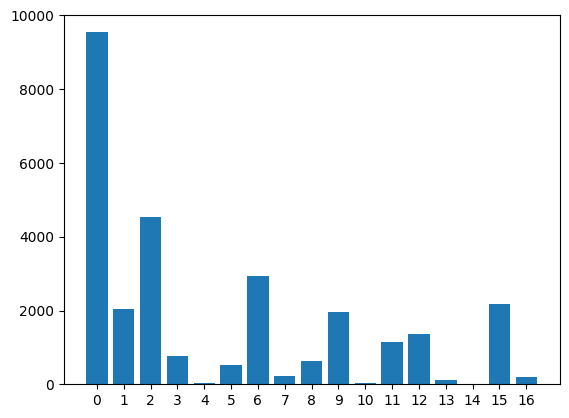

In [26]:
# Create a count plot
tags = [tag for sample in test_dataset['upos'] for tag in sample]
tags_counter = Counter(tags)
plt.xticks(range(number_of_tags))
plt.bar(tags_counter.keys(),tags_counter.values())

In [27]:
tags_counter.most_common()

[(0, 9543),
 (2, 4528),
 (6, 2937),
 (15, 2189),
 (1, 2051),
 (9, 1963),
 (12, 1370),
 (11, 1133),
 (3, 779),
 (8, 623),
 (5, 534),
 (7, 226),
 (16, 197),
 (13, 104),
 (4, 41),
 (10, 31)]

In [28]:
sum(tags_counter.values())

28249

tags counter on train set

<BarContainer object of 17 artists>

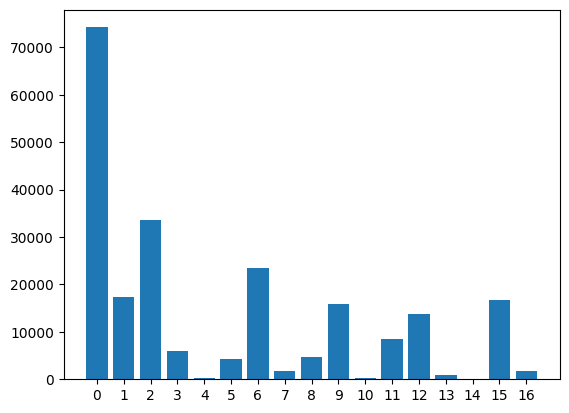

In [29]:
# Create a count plot
tags = [tag for sample in train_dataset['upos'] for tag in sample]
tags_counter = Counter(tags)
plt.xticks(range(number_of_tags))
plt.bar(tags_counter.keys(),tags_counter.values())

In [30]:
sum(tags_counter.values())

222933

In [31]:
tags_counter.most_common()

[(0, 74211),
 (2, 33516),
 (6, 23421),
 (1, 17424),
 (15, 16736),
 (9, 15768),
 (12, 13658),
 (11, 8474),
 (3, 5949),
 (8, 4622),
 (5, 4355),
 (7, 1703),
 (16, 1696),
 (13, 877),
 (4, 329),
 (10, 187),
 (14, 7)]

testset and trainset vocabulary and tokens count:


In [32]:
vocabs_dict = {}
for tokens_list in test_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('6,436', '28,249')

In [33]:
vocabs_dict = {}
for tokens_list in validation_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('6,834', '30,177')

In [34]:
vocabs_dict = {}
for tokens_list in train_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('21,908', '222,933')

# create helper functions and set constants

In [35]:
max(map(len,train_dataset['tokens'])),max(map(len,test_dataset['tokens']))

(398, 263)

In [36]:
# setting seq_len:
seq_len = 400
pad_tag = number_of_tags # tags starts from zero :)

In [37]:
def create_features_from_tokens_list(tokens_list,tags_list,tokenizer):
  encoded = list()
  padded_tags = list()
  for tokens,tags in tqdm(zip(tokens_list,tags_list)):
    text = ' '.join(tokens)
    encoded_doc = tokenizer.encode(text)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
    padded_tags.append(np.pad(
        tags,
        pad_width=(0,seq_len-len(tags)),
        constant_values=pad_tag,
      )
    )
  return np.array(encoded),np.array(padded_tags)

In [38]:
# define batch size
batch_size = 256

# Build the BiLSTM Model

## The Model Architecture

In [39]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        pad_id=1, # the default value from tkseem tokenizers
        pad_tag=pad_tag,
        seq_len=seq_len,
        output_size=18, # one class is added for padding
        hidden_size=512,
        embedding_size=512,
        embedding_dropout=0.5,
        dropout=0.5,
        learning_rate=0.001,
        n_layers=5,
        bidirectional=True,
      ):
        super().__init__()

        self.save_hyperparameters()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout
        self.pad_tag = pad_tag
        self.pad_id = pad_id
        self.max_sequence_length = seq_len
        self.output_size = output_size

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        
        self.test_recall = torchmetrics.Recall(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
      
        self.test_precision = torchmetrics.Precision(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        
        self.test_f1_score = torchmetrics.F1Score(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        outputs = self.embedding(inputs)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        inputs_lengths = torch.sum(inputs!=self.pad_id,axis=-1).cpu()
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs,
            inputs_lengths,
            batch_first=True,
            enforce_sorted=False,
          )
        if not self.bidirectional:
          # pass forward to lstm
          packed_outputs, _ =  self.lstm(packed_outputs)
          outputs,lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        else:
          bidirectional_packed_outputs,_ = self.lstm(packed_outputs)
          bidirectional_outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              bidirectional_packed_outputs,
              batch_first=True,
              # padding_value=self.pad_id,
              total_length=self.max_sequence_length,
            )
          outputs = bidirectional_outputs[:, :, : self.hidden_size] + bidirectional_outputs[:, :, self.hidden_size :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        assert torch.sum(inputs==self.pad_id)==torch.sum(labels==self.pad_tag),\
             f'pad ids and their target tags does not match: {torch.sum(inputs==self.pad_id):=} != {torch.sum(labels==self.pad_tag):=}'
        outputs = self(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1],-1)
        labels = labels.view(-1)
        return outputs,labels

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        test_accuracy = self.test_accuracy(outputs,labels)
        test_precision = self.test_precision(outputs,labels)
        test_recall = self.test_recall(outputs,labels)
        test_f1_score = self.test_f1_score(outputs,labels)
        metrics = {
          "test_acc": test_accuracy,
          "test_precision": test_precision,
          "test_recall": test_recall,
          "test_f1_score": test_f1_score,
          "test_loss": loss,
          
        }
        self.log_dict(metrics, prog_bar=True)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

## util classes/functions

In [40]:
class ConfusionMatrixCallback(Callback):
  def __init__(self,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.predictions = list()
    self.labels = list()

  def on_test_batch_end(self,trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
    super().on_test_batch_end(
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
      )
    inputs,labels = batch
    outputs = outputs.view(inputs.shape[0]*inputs.shape[1],-1)
    batch_predictions = torch.argmax(outputs,dim=-1)
    self.predictions.append(batch_predictions)
    labels = labels.view(-1)
    self.labels.append(labels)

  def on_test_end(self, trainer, pl_module) -> None:
     super().on_test_end(trainer, pl_module)
     predictions = torch.cat(self.predictions).cpu()
     labels = torch.cat(self.labels).cpu()
     confusion_matrix_calculator = torchmetrics.ConfusionMatrix(
            task="multiclass",
            num_classes=trainer.model.output_size,
            ignore_index=trainer.model.pad_tag,
     )
     confusion_matrix = confusion_matrix_calculator(predictions,labels)
     # zero out lists for future calculations
     self.predictions = list()
     self.labels = list()
     plt.figure(figsize = (10,7))
     sns.heatmap(confusion_matrix, annot=True,linewidths=0.5,fmt='g',cmap='Blues')

In [41]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./POSTagging/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  confusion_matrix_callback = ConfusionMatrixCallback()
  callbacks.append(confusion_matrix_callback)
  callbacks.append(RichProgressBar())
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=10,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  callbacks.append(EpochTimerCallback(log_results=False))
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      devices=[1],
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Dotted Text

## Prepare the tokenizer

In [42]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [43]:
tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens']))

Training WordTokenizer ...


In [44]:
tokenizer.vocab_size

21910

In [45]:
# test the tokenizer
tokenizer.tokenize('السلام على , hello')

['السلام', 'على', ',', '<UNK>']

## tokenize and split

In [46]:
encoded_trainset,trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens'],
    tags_list=train_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_valset,valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens'],
    tags_list=validation_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_testset,testy = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens'],
    tags_list=test_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_trainset.shape,trainy.shape,encoded_valset.shape,valy.shape,encoded_testset.shape,testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((5934, 400), (5934, 400), (906, 400), (906, 400), (674, 400), (674, 400))

In [47]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [48]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [49]:
model = LitBiLSTMModel(vocab_size=tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (test_recall): MulticlassRecall()
  (test_precision): MulticlassPrecision()
  (test_f1_score): MulticlassF1Score()
  (embedding): Embedding(21910, 512)
  (lstm): LSTM(512, 512, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=18, bias=True)
)

In [50]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='dotted-text',
  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.8850133419036865     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name              ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ train_accuracy    │ MulticlassAccuracy  │      0 │
│ 1  │ val_accuracy      │ MulticlassAccuracy  │      0 │
│ 2  │ test_accuracy     │ MulticlassAccuracy  │      0 │
│ 3  │ test_recall       │ MulticlassRecall    │      0 │
│ 4  │ test_precision    │ MulticlassPrecision │      0 │
│ 5  │ test_f1_score     │ MulticlassF1Score   │      0 │
│ 6  │ embedding         │ Embedding           │ 11.2 M │
│ 7  │ lstm              │ LSTM                │ 29.4 M │
│ 8  │ dropout           │ Dropout             │      0 │
│ 9  │ embedding_dropout │ Dropout             │      0 │
│ 10 │ fc                │ Linear              │  9.2 K │
└────┴───────────────────┴─────────────────────┴────────┘

Trainable params: 40.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 40.6 M                                                                                               
Total estimated model params size (MB): 162

Output()

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.

Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.

Restoring states from the checkpoint path at /home/majed_alshaibani/Experiments/DotlessArabic/POSTagging/dotted-text/checkpoints/epoch=22-val_loss=0.188-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/majed_alshaibani/Experiments/DotlessArabic/POSTagging/dotted-text/checkpoints/epoch=22-val_loss=0.188-step=540.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9439883828163147     │
│       test_f1_score       │    0.8906850218772888     │
│         test_loss         │    0.2036372721195221     │
│      test_precision       │     0.904967725276947     │
│        test_recall        │    0.8843591213226318     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9439883828163147,
  'test_precision': 0.904967725276947,
  'test_recall': 0.8843591213226318,
  'test_f1_score': 0.8906850218772888,
  'test_loss': 0.2036372721195221}]

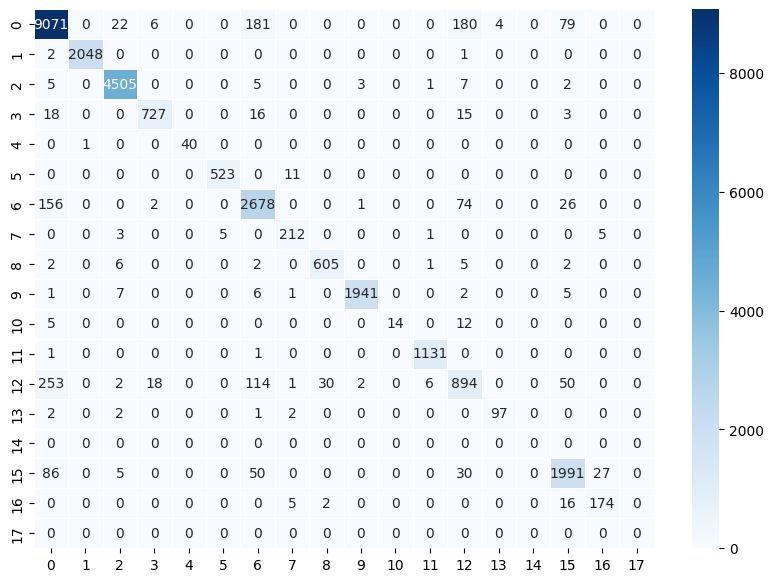

In [51]:
#9119 test on the last model
trainer.test(model,testloader,ckpt_path='best')

In [52]:
epoch_timer_callback = list(filter(lambda callback: callback.__class__ == EpochTimerCallback , trainer.callbacks))[0]


In [53]:
epoch_timer_callback.average_epochs_time

12.90716120174953

# Dotless Text

## prepare the dataset

In [54]:
train_dataset['dotless_tokens'] = list(train_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens))))
train_dataset

  0%|          | 0/5934 [00:00<?, ?it/s]

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc,dotless_tokens
0,afp.20000715.0075:p1u1,برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[بَرلِين, رَفَض, حُصُول, شَرِكَة, أَمِيرِكِيّ,...","[12, 15, 0, 0, 6, 2, 0, 0, 0, 1, 12, 1, 6]","[X---------, VIIA-3FS--, N------S4R, N------S2...","[{'Foreign': 'Yes'}, {'Aspect': 'Imp', 'Gender...","[2, 0, 2, 3, 4, 7, 3, 7, 8, 11, 9, 11, 9]","[nsubj, root, obj, nmod, amod, case, obl:arg, ...","[[('nsubj', 2)], [('root', 0)], [('obj', 2)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root...","[ٮرلٮں, ٮرڡص, حصول, سركه, امٮركٮه, على, رحصه, ..."
1,afp.20000715.0075:p2u1,برلين 15-7 (اف ب) - افادت صحيفة الاحد الالماني...,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[بَرلِين, 15, -, 7, (, اف, ب, ), -, أَفَاد, صَ...","[12, 3, 1, 3, 1, 12, 12, 1, 1, 15, 0, 0, 6, 1,...","[X---------, Q---------, G---------, Q--------...","[{'Foreign': 'Yes'}, {'NumForm': 'Digit'}, Non...","[0, 1, 4, 2, 7, 7, 1, 7, 10, 1, 10, 11, 11, 17...","[root, dep, punct, conj, punct, nmod, dep, pun...","[[('root', 0)], [('dep', 1)], [('punct', 4)], ...","[{'Vform': 'بَرلِين', 'Gloss': 'Berlin', 'Root...","[ٮرلٮں, 15, -, 7, (, اڡ, ٮ, ), -, اڡادٮ, صحٮڡه..."
2,afp.20000715.0075:p3u1,وفي نيسان/ابريل الماضي، تخلت الدولة الاسبانية ...,"[و, في, نيسان, /, ابريل, الماضي, ،, تخلت, الدو...","[_, وَ, فِي, نِيسَان, /, أَبرِيل, مَاضِي, ،, ت...","[9, 2, 0, 1, 0, 6, 1, 15, 0, 6, 2, 0, 1, 12, 1...","[None, C---------, P---------, N------S2I, G--...","[None, None, {'AdpType': 'Prep'}, {'Case': 'Ge...","[None, 0, 3, 8, 5, 3, 3, 6, 1, 8, 9, 12, 8, 15...","[_, root, case, obl, punct, appos, amod, punct...","[None, [('root', 0)], [('case', 3)], [('obl:فِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, ڡى, ٮٮساں, /, اٮرٮل, الماصى, ،, ٮحلٮ, الدو..."
3,afp.20000715.0075:p4u1,وكانت خسائر المجموعة الاسبانية الرسمية تراكمت ...,"[و, كانت, خسائر, المجموعة, الاسبانية, الرسمية,...","[_, وَ, كَان, خَسَارَة, مَجمُوعَة, إِسبَانِيّ,...","[9, 15, 0, 0, 6, 6, 15, 2, 0, 3, 6, 9, 15, 3, ...","[None, C---------, VP-A-3FS--, N------P1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 4, 3, 2, 9, 7, 9, 9, None, ...","[_, root, parataxis, nsubj, nmod, amod, amod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, كاٮٮ, حساىر, المحموعه, الاسٮاٮٮه, الرسمٮه,..."
4,afp.20000715.0075:p5u1,واشارت صحيفة الاحد الى ان المستشار شرودر يعتبر...,"[و, أشارت, صحيفة, الاحد, الى, ان, المستشار, شر...","[_, وَ, أَشَار, صَحِيفَة, أَحَد, إِلَى, أَنَّ,...","[9, 15, 0, 0, 2, 5, 0, 12, 15, 5, 0, 0, 6, 2, ...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 9, 9, 9, 7, 2, 19, 19, 11, ...","[_, root, parataxis, nsubj, nmod, mark, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, اسارٮ, صحٮڡه, الاحد, الى, اں, المسٮسار, سر..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6070,xinhua.20030511.0192:p3u1,تلقى وزير الخارجية المصرى احمد ماهر هنا مساء ا...,"[تلقى, وزير, الخارجية, المصرى, احمد, ماهر, هنا...","[تَلَقَّى, وَزِير, خَارِجِيَّة, مِصرِيّ, احمد,...","[15, 0, 0, 6, 12, 12, 12, 12, 0, 12, 0, 6, 2, ...","[VP-A-3MS--, N------S1R, N------S2D, A-----MS1...","[{'Aspect': 'Perf', 'Gender': 'Masc', 'Number'...","[0, 1, 2, 2, 6, 2, 1, 1, 8, 8, 1, 11, 14, None...","[root, nsubj, nmod, amod, nmod, nmod, obl, obl...","[[('root', 0)], [('nsubj', 1)], [('nmod:gen', ...","[{'Vform': 'تَلَقَّى', 'Gloss': 'receive', 'Ro...","[ٮلڡى, ورٮر, الحارحٮه, المصرى, احمد, ماهر, هٮا..."
6071,xinhua.20030511.0192:p4u1,وقالت وكالة انباء الشرق الاوسط المصرية ان شعث ...,"[و, قالت, وكالة, انباء, الشرق, الاوسط, المصرية...","[_, وَ, قَال, وِكَالَة, نَبَأ, شَرق, أَوسَط, م...","[9, 15, 0, 0, 0, 6, 6, 5, 12, 15, 12, 0, 0, 8,...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspec

In [55]:
train_dataset['dotless_tokens'][0],train_dataset['tokens'][0]

(['ٮرلٮں',
  'ٮرڡص',
  'حصول',
  'سركه',
  'امٮركٮه',
  'على',
  'رحصه',
  'ٮصٮٮع',
  'دٮاٮه',
  '"',
  'لٮوٮارد',
  '"',
  'الالماٮٮه'],
 array(['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع',
        'دبابة', '"', 'ليوبارد', '"', 'الالمانية'], dtype=object))

In [56]:
validation_dataset['dotless_tokens'] = validation_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens)))
validation_dataset

  0%|          | 0/906 [00:00<?, ?it/s]

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc,dotless_tokens
0,afp.20000715.0001:p1u1,ميراث ب300 الف دولار يقلب حياة متشرد اميركي,"[ميراث, ب, 300, الف, دولار, يقلب, حياة, متشرد,...","[مِيرَاث, بِ, 300, أَلف, دُولَار, قَلَّب, حَيَ...","[0, 2, 3, 3, 0, 15, 0, 6, 6]","[N------S1I, P---------, Q---------, QM-----S2...","[{'Case': 'Nom', 'Definite': 'Ind', 'Number': ...","[6, 3, 1, 3, 4, 0, 6, 7, 8]","[nsubj, case, nummod, nummod, nmod, root, obj,...","[[('nsubj', 6)], [('case', 3)], [('nummod', 1)...","[{'Vform': 'مِيرَاثٌ', 'Gloss': 'inheritance,h...","[مٮراٮ, ٮ, 300, الڡ, دولار, ٮڡلٮ, حٮاه, مٮسرد,..."
1,afp.20000715.0001:p2u1,لونغ بيتش (الولايات المتحدة) 15-7 (اف ب)- كل ش...,"[لونغ, بيتش, (, الولايات, المتحدة, ), 15, -, 7...","[لُونغ, بِيتش, (, وِلَايَة, مُتَّحِد, ), 15, -...","[12, 12, 1, 0, 6, 1, 3, 1, 3, 1, 12, 12, 1, 1,...","[X---------, X---------, G---------, N------P1...","[{'Foreign': 'Yes'}, {'Foreign': 'Yes'}, None,...","[0, 1, 4, 1, 4, 4, 1, 7, 7, 1, 1, 1, 1, 1, 17,...","[root, flat:foreign, punct, appos, amod, punct...","[[('root', 0)], [('flat:foreign', 1)], [('punc...","[{'Vform': 'لُونغ', 'Gloss': 'Long', 'Root': '...","[لوٮع, ٮٮٮس, (, الولاٮاٮ, المٮحده, ), 15, -, 7..."
2,afp.20000715.0001:p3u1,وغادر كنت (45 عاما) مساء الاربعاء المدينة متوج...,"[و, غادر, كنت, (, 45, عاما, ), مساء, الاربعاء,...","[_, وَ, غَادَر, كِنت, (, 45, عَام, ), مَسَاء, ...","[9, 15, 12, 1, 3, 0, 1, 0, 0, 0, 6, 2, 0, 12, ...","[None, C---------, VP-A-3MS--, X---------, G--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 3, 5, 5, 2, 8, 2, 2, 13, 11...","[_, root, parataxis, nsubj, punct, dep, nmod, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, عادر, كٮٮ, (, 45, عاما, ), مساء, الارٮعاء,..."
3,afp.20000715.0001:p4u1,وبدا ستيفن كنت نحيلا جدا، الا انه اغتسل وحلق ذ...,"[و, بدا, ستيفن, كنت, نحيلا, جدا, ،, الا, أن, ه...","[_, وَ, بَدَا, ستِيفِن, كِنت, نَحِيل, جِدّ, ،,...","[9, 15, 12, 12, 6, 0, 1, 7, 5, 11, 15, 9, 15, ...","[None, C---------, VP-A-3MS--, X---------, X--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 2, 5, 6, 11, None, 11, 11, ...","[_, root, parataxis, nsubj, flat:foreign, xcom...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, ٮدا, سٮٮڡں, كٮٮ, ٮحٮلا, حدا, ،, الا, اں, ه..."
4,afp.20000715.0001:p4u2,وبما ان المناسبة تستحق العناء اشترى سروالا ازر...,"[و, ب, ما, ان, المناسبة, تستحق, العناء, اشترى,...","[_, وَ, بِ, مَا, أَنَّ, مُنَاسَبَة, اِستَحَقّ,...","[9, 2, 8, 5, 0, 15, 0, 15, 0, 6, 9, 0, 6, 9, 0...","[None, C---------, P---------, S---------, C--...","[None, None, {'AdpType': 'Prep'}, None, None, ...","[None, 0, 3, 8, 6, 6, 3, 6, 1, 8, 9, None, 12,...","[_, root, case, obl, mark, nsubj, advcl, obj, ...","[None, [('root', 0)], [('case', 3)], [('obl:بِ...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, ٮ, ما, اں, المٮاسٮه, ٮسٮحٯ, العٮاء, اسٮرى,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
904,ummah.20040906.0013:p25u2,ـ لا نزورهم كونهم معتقلين لدى قوات التحالف.,"[ـ, لا, نزور, هم, كون, هم, معتقلين, لدى, قوات,...","[ـ, لَا, _, زَار, هُوَ, _, كَون, هُوَ, مُعتَقَ...","[1, 7, 15, 11, 0, 11, 0, 2, 0, 0, 1]","[G---------, F---------, None, VIIA-1MP--, SP-...","[None, None, None, {'Aspect': 'Imp', 'Gender':...","[3, 3, None, 0, 3, None, 3, 5, 3, 9, 3, 9, 3]","[punct, advmod, _, root, obj, _, obj, nmod, ob...","[[('punct', 3)], [('advmod', 3)], None, [('roo...","[{'Vform': 'ـ', 'Translit': None}, {'Vform': '...","[ـ, لا, ٮرور, هم, كوں, هم, معٮڡلٮں, لدى, ڡواٮ,..."
905,ummah.20040906.0013:p26u1,* ومتى سيتم تسليمهم إليكم؟,"[*, و, متى, س, يتم, تسليم, هم, إلي, كم, ؟]","[*, _, وَ, مَتَى, _, سَ, تَمّ, _, تَسلِيم, هُو...","[1, 9, 8, 16, 15, 0, 11, 2, 11, 1]","[G---------, None, C---------, S---------, Non...","[None, None, None, None, None, None, {'Aspect'...","[2, None, 0, 5, None, 5, 2, None, 5, 6, None, ...","[punct, _, root, obl

In [57]:
test_dataset['dotless_tokens'] = test_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens)))
test_dataset

  0%|          | 0/674 [00:00<?, ?it/s]

,idx,text,tokens,lemmas,upos,xpos,feats,head,deprel,deps,misc,dotless_tokens
0,assabah.20041005.0017:p1u1,سوريا: تعديل وزاري واسع يشمل 8 حقائب,"[سوريا, :, تعديل, وزاري, واسع, يشمل, 8, حقائب]","[سُورِيَا, :, تَعدِيل, وِزَارِيّ, وَاسِع, شَمِ...","[12, 1, 0, 6, 6, 15, 3, 0]","[X---------, G---------, N------S1I, A-----MS1...","[{'Foreign': 'Yes'}, None, {'Case': 'Nom', 'De...","[0, 1, 6, 3, 3, 1, 6, 7]","[root, punct, nsubj, amod, amod, parataxis, ob...","[[('root', 0)], [('punct', 1)], [('nsubj', 6)]...","[{'SpaceAfter': 'No', 'Vform': 'سُورِيَا', 'Gl...","[سورٮا, :, ٮعدٮل, ورارى, واسع, ٮسمل, 8, حڡاىٮ]"
1,assabah.20041005.0017:p2u1,دمشق (وكالات الانباء) - اجرى الرئيس السوري بشا...,"[دمشق, (, وكالات, الانباء, ), -, اجرى, الرئيس,...","[دمشق, (, وِكَالَة, نَبَأ, ), -, أَجرَى, رَئِي...","[12, 1, 0, 0, 1, 1, 15, 0, 6, 12, 12, 0, 6, 6,...","[U---------, G---------, N------P1R, N------P2...","[None, None, {'Case': 'Nom', 'Definite': 'Cons...","[0, 3, 1, 3, 3, 1, 1, 7, 8, 11, 8, 7, 12, 12, ...","[root, punct, dep, nmod, punct, punct, advcl, ...","[[('root', 0)], [('punct', 3)], [('dep', 1)], ...","[{'Vform': 'دمشق', 'Root': 'OOV', 'Translit': ...","[دمسٯ, (, وكالاٮ, الاٮٮاء, ), -, احرى, الرىٮس,..."
2,assabah.20041005.0017:p3u1,واضافت المصادر ان مهدي دخل الله رئيس تحرير صحي...,"[و, أضافت, المصادر, ان, مهدي, دخل, الله, رئيس,...","[_, وَ, أَضَاف, مَصدَر, أَنَّ, مهدي, دخل, الله...","[9, 15, 0, 5, 12, 12, 12, 0, 0, 0, 0, 0, 9, 6,...","[None, C---------, VP-A-3FS--, N------P1D, C--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 16, 6, 16, 6, 6, 8, 9, 10, 11,...","[_, root, parataxis, nsubj, mark, nmod, nsubj,...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, اصاڡٮ, المصادر, اں, مهدى, دحل, الله, رىٮس,..."
3,assabah.20041005.0017:p4u1,وذكرت وكالة الانباء السورية ان التعديل شمل ثما...,"[و, ذكرت, وكالة, الانباء, السورية, ان, التعديل...","[_, وَ, ذَكَر, وِكَالَة, نَبَأ, سُورِيّ, أَنَّ...","[9, 15, 0, 0, 6, 5, 0, 15, 3, 0, 2, 11, 0, 6, ...","[None, C---------, VP-A-3FS--, N------S1R, N--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Fem...","[None, 0, 1, 2, 3, 3, 8, 8, 2, 8, 9, None, 12,...","[_, root, parataxis, nsubj, nmod, amod, mark, ...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, دكرٮ, وكاله, الاٮٮاء, السورٮه, اں, الٮعدٮل..."
4,assabah.20041005.0017:p5u1,وعين اللواء كنعان الذي كان رئيسا لجهاز الامن ا...,"[و, عين, اللواء, كنعان, الذي, كان, رئيسا, ل, ج...","[_, وَ, عَيَّن, اللواء, كنعان, الذي, كَان, رَئ...","[9, 15, 12, 12, 12, 16, 0, 2, 0, 0, 6, 0, 2, 6...","[None, C---------, VP-P-3MS--, U---------, U--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 3, 3, 7, 3, None, 9, 7, 9, 10,...","[_, root, parataxis, nsubj:pass, nmod, cc, cop...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, عٮں, اللواء, كٮعاں, الدى, كاں, رىٮسا, ل, ح..."
...,...,...,...,...,...,...,...,...,...,...,...,...
675,xinhua.20030511.0181:p10u1,وقتل مسلحان فى مواجهة مع فريق مشرتك من الشرطة ...,"[و, قتل, مسلحان, فى, مواجهة, مع, فريق, مشرتك, ...","[_, وَ, قَتَل, مُسَلَّح, فِي, مُوَاجِه, مَعَ, ...","[9, 15, 0, 2, 6, 2, 0, 12, 2, 0, 9, 0, 0, 2, 1...","[None, C---------, VP-P-3MS--, N------D1I, P--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","[None, 0, 1, 2, 5, 2, 7, 5, 7, 10, 7, None, 12...","[_, root, parataxis, nsubj:pass, case, obl, ca...","[None, [('root', 0)], [('parataxis', 1)], [('n...","[None, {'Vform': 'وَ', 'Gloss': 'and', 'Root':...","[و, ڡٮل, مسلحاں, ڡى, مواحهه, مع, ڡرٮٯ, مسرٮك, ..."
676,xinhua.20030511.0181:p11u1,ولقى مسلحان اخران مصرعهما فى اشتباك مع قوات ال...,"[و, لقي, مسلحان, اخران, مصرع, هما, فى, اشتباك,...","[_, وَ, لَقِي, مُسَلَّح, آخَر, _, مَصرَع, هُوَ...","[9, 15, 0, 6, 0, 11, 2, 12, 2, 0, 0, 2, 12, 12...","[None, C---------, VP-A-3MS--, N------D1I, A--...","[None, None, {'Aspect': 'Perf', 'Gender': 'Mas...","

In [58]:
test_dataset['dotless_tokens'][0],test_dataset['tokens'][0]

(['سورٮا', ':', 'ٮعدٮل', 'ورارى', 'واسع', 'ٮسمل', '8', 'حڡاىٮ'],
 array(['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب'],
       dtype=object))

## create the tokenizer

In [59]:
dotless_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [60]:
dotless_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['dotless_tokens']))

Training WordTokenizer ...


In [61]:
dotless_tokenizer.vocab_size

18889

In [62]:
# test the tokenizer
dotless_tokenizer.tokenize('على في , hello')

['على', '<UNK>', ',', '<UNK>']

## tokenize and split

In [63]:
dotless_encoded_trainset,dotless_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['dotless_tokens'],
    tags_list=train_dataset['upos'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_valset,dotless_valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['dotless_tokens'],
    tags_list=validation_dataset['upos'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_testset,dotless_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['dotless_tokens'],
    tags_list=test_dataset['upos'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_trainset.shape,dotless_trainy.shape,dotless_encoded_valset.shape,dotless_valy.shape,dotless_encoded_testset.shape,dotless_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((5934, 400), (5934, 400), (906, 400), (906, 400), (674, 400), (674, 400))

In [64]:
# create tensor datasets
dotless_trainset = TensorDataset(torch.from_numpy(dotless_encoded_trainset), torch.from_numpy(dotless_trainy))
dotless_validset = TensorDataset(torch.from_numpy(dotless_encoded_valset), torch.from_numpy(dotless_valy))
dotless_testset = TensorDataset(torch.from_numpy(dotless_encoded_testset), torch.from_numpy(dotless_testy))

In [65]:
# create dataloaders
dotless_trainloader = DataLoader(dotless_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
dotless_valloader = DataLoader(dotless_validset, shuffle=False, batch_size=batch_size,num_workers=4)
dotless_testloader = DataLoader(dotless_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [66]:
model = LitBiLSTMModel(vocab_size=dotless_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (test_recall): MulticlassRecall()
  (test_precision): MulticlassPrecision()
  (test_f1_score): MulticlassF1Score()
  (embedding): Embedding(18889, 512)
  (lstm): LSTM(512, 512, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=18, bias=True)
)

In [67]:
trainer = train_model(
    model,
    train_dataloader=dotless_trainloader,
    val_dataloader=dotless_valloader,
    text_type='dotless-text',
  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.8951613903045654     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name              ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ train_accuracy    │ MulticlassAccuracy  │      0 │
│ 1  │ val_accuracy      │ MulticlassAccuracy  │      0 │
│ 2  │ test_accuracy     │ MulticlassAccuracy  │      0 │
│ 3  │ test_recall       │ MulticlassRecall    │      0 │
│ 4  │ test_precision    │ MulticlassPrecision │      0 │
│ 5  │ test_f1_score     │ MulticlassF1Score   │      0 │
│ 6  │ embedding         │ Embedding           │  9.7 M │
│ 7  │ lstm              │ LSTM                │ 29.4 M │
│ 8  │ dropout           │ Dropout             │      0 │
│ 9  │ embedding_dropout │ Dropout             │      0 │
│ 10 │ fc                │ Linear              │  9.2 K │
└────┴───────────────────┴─────────────────────┴────────┘

Trainable params: 39.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 39.1 M                                                                                               
Total estimated model params size (MB): 156

Output()

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.

Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.

Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.

Restoring states from the checkpoint path at /home/majed_alshaibani/Experiments/DotlessArabic/POSTagging/dotless-text/checkpoints/epoch=13-val_loss=0.227-step=336.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/majed_alshaibani/Experiments/DotlessArabic/POSTagging/dotless-text/checkpoints/epoch=13-val_loss=0.227-step=336.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.933922290802002     │
│       test_f1_score       │    0.8750104308128357     │
│         test_loss         │     0.235791876912117     │
│      test_precision       │    0.9016573429107666     │
│        test_recall        │    0.8612464666366577     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.933922290802002,
  'test_precision': 0.9016573429107666,
  'test_recall': 0.8612464666366577,
  'test_f1_score': 0.8750104308128357,
  'test_loss': 0.235791876912117}]

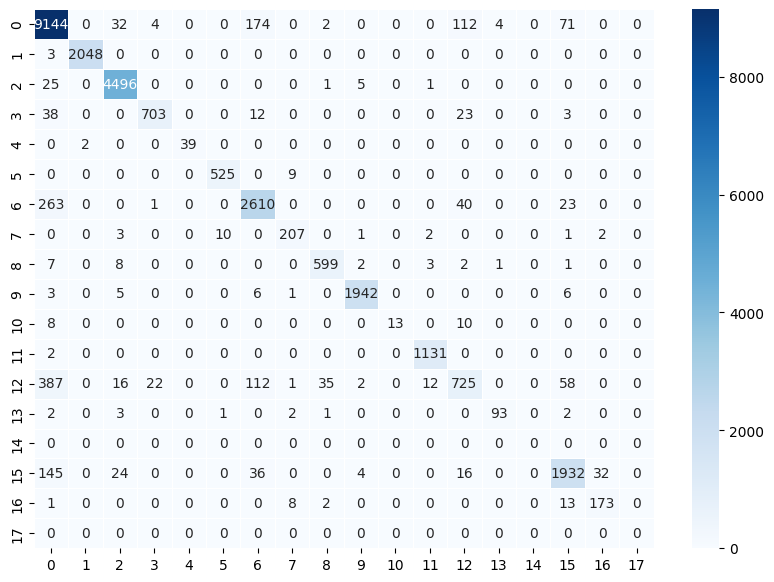

In [68]:
# test on the last model
trainer.test(model,dotless_testloader,ckpt_path='best')

In [69]:
epoch_timer_callback = list(filter(lambda callback: callback.__class__ == EpochTimerCallback , trainer.callbacks))[0]

In [70]:
epoch_timer_callback.average_epochs_time

13.20243299634833